In [19]:
!pip install pandas google-generativeai sqlalchemy matplotlib


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\sanju\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [20]:
import pandas as pd
import sqlite3
import google.generativeai as genai
import os
import matplotlib.pyplot as plt
import io
import base64
from IPython.display import display, HTML

# Suppress matplotlib warnings for cleaner output
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [22]:
import pandas as pd

# Define file paths for the uploaded CSVs (from Downloads folder)
ad_sales_filepath = r'C:\Users\sanju\Downloads\Product-Level Ad Sales and Metrics.csv'
total_sales_filepath = r'C:\Users\sanju\Downloads\Product-Level Total Sales and Metrics.csv'
eligibility_filepath = r'C:\Users\sanju\Downloads\Product-Level Eligibility Table.csv'

# Load DataFrames from CSV files
try:
    df_ad_sales = pd.read_csv(ad_sales_filepath, parse_dates=['date'], encoding='ISO-8859-1')
    df_total_sales = pd.read_csv(total_sales_filepath, parse_dates=['date'], encoding='ISO-8859-1')
    df_eligibility = pd.read_csv(eligibility_filepath, parse_dates=['eligibility_datetime_utc'], encoding='ISO-8859-1')

    print("DataFrames loaded successfully from CSV files.")
    print(f"df_ad_sales shape: {df_ad_sales.shape}")
    print(f"df_total_sales shape: {df_total_sales.shape}")
    print(f"df_eligibility shape: {df_eligibility.shape}")

    # Display first few rows to confirm
    print("\n--- df_ad_sales head ---")
    print(df_ad_sales.head())
    print("\n--- df_total_sales head ---")
    print(df_total_sales.head())
    print("\n--- df_eligibility head ---")
    print(df_eligibility.head())

except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure all three CSV files exist at the specified paths.")
except Exception as e:
    print(f"An error occurred while reading CSV files: {e}")


DataFrames loaded successfully from CSV files.
df_ad_sales shape: (3696, 7)
df_total_sales shape: (702, 4)
df_eligibility shape: (4381, 4)

--- df_ad_sales head ---
        date  item_id  ad_sales  impressions  ad_spend  clicks  units_sold
0 2025-06-01        0    332.96         1963     16.87       8           3
1 2025-06-01        1      0.00         1764     20.39      11           0
2 2025-06-01        2     95.99          169      0.48       0           1
3 2025-06-01        3   1001.93         6943     75.69      31           9
4 2025-06-01        4   1096.98        59046    401.39     285           5

--- df_total_sales head ---
        date  item_id  total_sales  total_units_ordered
0 2025-06-01        0       309.99                    1
1 2025-06-01        3       338.00                    2
2 2025-06-01        4       617.99                    3
3 2025-06-01        9       219.00                    1
4 2025-06-01       12       534.00                    3

--- df_eligibility 

In [23]:
# Connect to an in-memory SQLite database
# For persistent storage, replace ':memory:' with a file path like 'ecommerce_data.db'
conn = sqlite3.connect(':memory:')

# Write DataFrames to SQL tables
# Ensure DataFrames were loaded successfully before attempting to_sql
if 'df_ad_sales' in locals() and not df_ad_sales.empty:
    df_ad_sales.to_sql('ad_sales_metrics', conn, if_exists='replace', index=False)
    print("ad_sales_metrics table created.")
else:
    print("df_ad_sales is empty or not loaded. Skipping ad_sales_metrics table creation.")

if 'df_total_sales' in locals() and not df_total_sales.empty:
    df_total_sales.to_sql('total_sales_metrics', conn, if_exists='replace', index=False)
    print("total_sales_metrics table created.")
else:
    print("df_total_sales is empty or not loaded. Skipping total_sales_metrics table creation.")

if 'df_eligibility' in locals() and not df_eligibility.empty:
    df_eligibility.to_sql('product_eligibility', conn, if_exists='replace', index=False)
    print("product_eligibility table created.")
else:
    print("df_eligibility is empty or not loaded. Skipping product_eligibility table creation.")

print("\nData loading into SQLite database attempted.")

# Get and print schema for LLM context
def get_schema(connection):
    cursor = connection.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
    tables = cursor.fetchall()
    schema_info = ""
    for table_name_tuple in tables:
        table_name = table_name_tuple[0]  # Corrected: Access the first element of the tuple
        schema_info += f"CREATE TABLE {table_name} (\n"
        cursor.execute(f"PRAGMA table_info({table_name});")
        columns = cursor.fetchall()
        col_defs = []  # Corrected: Initialize col_defs as an empty list
        for col in columns:
            cid, name, type, notnull, dflt_value, pk = col
            col_defs.append(f"  {name} {type}{' PRIMARY KEY' if pk else ''}{' NOT NULL' if notnull and not pk else ''}")
        schema_info += ",\n".join(col_defs)
        schema_info += "\n);\n\n"
    return schema_info

db_schema = get_schema(conn)
print("\n--- Database Schema for LLM ---")
print(db_schema)
print("-----------------------------")

ad_sales_metrics table created.
total_sales_metrics table created.
product_eligibility table created.

Data loading into SQLite database attempted.

--- Database Schema for LLM ---
CREATE TABLE ad_sales_metrics (
  date TIMESTAMP,
  item_id INTEGER,
  ad_sales REAL,
  impressions INTEGER,
  ad_spend REAL,
  clicks INTEGER,
  units_sold INTEGER
);

CREATE TABLE total_sales_metrics (
  date TIMESTAMP,
  item_id INTEGER,
  total_sales REAL,
  total_units_ordered INTEGER
);

CREATE TABLE product_eligibility (
  eligibility_datetime_utc TIMESTAMP,
  item_id INTEGER,
  eligibility INTEGER,
  message TEXT
);


-----------------------------


In [24]:
# # Access the API key from Colab's user secrets
# # If you haven't set it up, go to the key icon on the left sidebar -> 'Secrets' -> Add a new secret named 'GEMINI_API_KEY'
# try:
#     from google.colab import userdata
#     GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
#     genai.configure(api_key=GEMINI_API_KEY)
#     print("Gemini API key configured from Colab secrets.")
# except Exception as e:
#     print(f"Could not load API key from Colab secrets: {e}")
#     print("Please ensure you have added your GEMINI_API_KEY to Colab secrets.")
#     # Fallback for local testing if not in Colab, or if user wants to paste directly (NOT RECOMMENDED FOR PRODUCTION)
#     # GEMINI_API_KEY = "YOUR_API_KEY_HERE"
#     # genai.configure(api_key=GEMINI_API_KEY)

# # Initialize the Gemini model
# model = genai.GenerativeModel('gemini-1.5-pro') # You can choose 'gemini-1.5-flash' or 'gemini-1.5-pro' for more advanced models if available and needed.
# print("Gemini model initialized.")

In [25]:
import sqlite3
import logging
from typing import List, Dict, Any, Optional

def ask_ai_agent(question: str, db_connection: sqlite3.Connection, schema: str) -> str:
    """
    Processes a natural language question to generate SQL, query the database,
    and return a human-readable answer.

    Args:
        question: Natural language question to process
        db_connection: SQLite database connection
        schema: Database schema information

    Returns:
        Human-readable answer or error message
    """

    def _generate_sql_query(question: str, schema: str) -> Optional[str]:
        """Generate SQL query using LLM."""
        prompt = f"""You are an expert SQL data analyst. Your task is to convert a user's question into a valid SQLite SQL query.
The database schema is provided below. Only output the SQL query. Do not add any explanation or any other text.
Do not use markdown backticks.

Database Schema:
{schema}

User's Question: {question}
SQL Query:"""

        print(f"--- Prompting LLM with question: '{question}' ---")

        try:
            response = model.generate_content(prompt)
            sql_query = response.text.strip()
            print(f"--- Generated SQL Query: ---\n{sql_query}\n----------------------------")
            return sql_query
        except Exception as e:
            logging.error(f"Error generating SQL query: {e}")
            return None

    def _execute_query(sql_query: str, db_connection: sqlite3.Connection) -> Optional[tuple]:
        """Execute SQL query and return results with column names."""
        try:
            cursor = db_connection.cursor()
            cursor.execute(sql_query)
            results = cursor.fetchall()
            column_names = [description[0] for description in cursor.description] if cursor.description else []
            print(f"--- Query Results: ---\n{results}\n----------------------")
            return results, column_names
        except sqlite3.Error as e:
            logging.error(f"Database error: {e}")
            return None

    def _format_results(results: List[tuple], column_names: List[str]) -> str:
        """Format query results into human-readable format."""
        if not results:
            return "No results found for your query."

        # Convert to list of dictionaries for easier processing
        formatted_results = [dict(zip(column_names, row)) for row in results]

        # Specialized formatting for common business metrics
        if len(formatted_results) == 1:  # Single result formatters
            single_result = formatted_results[0]

            # Total sales formatting
            if "total_sales" in column_names:
                total_sales = single_result['total_sales']
                return f"The total sales revenue is: ${total_sales:,.2f}"

            # ROAS formatting
            elif "roas" in column_names:
                roas_value = single_result['roas']
                return f"The Return on Ad Spend (ROAS) is: {roas_value:.2f}x. This means for every $1 spent on ads, ${roas_value:.2f} in revenue was generated."

            # Average formatting
            elif any(col.startswith('avg_') for col in column_names):
                avg_cols = [col for col in column_names if col.startswith('avg_')]
                response_lines = []
                for col in avg_cols:
                    metric_name = col.replace('avg_', '').replace('_', ' ').title()
                    value = single_result[col]
                    if isinstance(value, (int, float)):
                        response_lines.append(f"Average {metric_name}: {value:,.2f}")
                    else:
                        response_lines.append(f"Average {metric_name}: {value}")
                return "\n".join(response_lines)

        # Multi-result specialized formatters
        if "cpc" in column_names:
            response_lines = ["Here are the products with their Cost Per Click (CPC):"]
            for row in formatted_results:
                item_id = row.get('item_id', row.get('product_id', 'N/A'))
                product_name = row.get('product_name', f'Product ID: {item_id}')
                cpc_value = row.get('cpc', 0)
                response_lines.append(f"- {product_name}: ${cpc_value:.2f}")
            return "\n".join(response_lines)

        # Revenue/sales by category formatting
        elif any(col in column_names for col in ['revenue', 'sales']) and len(formatted_results) > 1:
            response_lines = ["Here are the results:"]
            for row in formatted_results:
                line_parts = []
                for col, value in row.items():
                    if isinstance(value, (int, float)) and col in ['revenue', 'sales', 'total_sales']:
                        line_parts.append(f"{col.replace('_', ' ').title()}: ${value:,.2f}")
                    else:
                        line_parts.append(f"{col.replace('_', ' ').title()}: {value}")
                response_lines.append(f"- {', '.join(line_parts)}")
            return "\n".join(response_lines)

        # Generic table formatting for complex results
        return _format_as_table(formatted_results, column_names)

    def _format_as_table(formatted_results: List[Dict[str, Any]], column_names: List[str]) -> str:
        """Format results as a readable table."""
        if not formatted_results:
            return "No results found."

        # Calculate column widths
        col_widths = {}
        for col in column_names:
            col_widths[col] = max(
                len(str(col)),
                max(len(str(row.get(col, ''))) for row in formatted_results)
            )

        # Create header
        header_parts = [col.replace('_', ' ').title().ljust(col_widths[col]) for col in column_names]
        header = " | ".join(header_parts)

        # Create separator
        separator = "-|-".join(['-' * col_widths[col] for col in column_names])

        # Create data rows
        data_rows = []
        for row in formatted_results:
            row_parts = []
            for col in column_names:
                value = row.get(col, '')
                # Format numbers nicely
                if isinstance(value, float):
                    if col in ['revenue', 'sales', 'total_sales', 'cost']:
                        formatted_value = f"${value:,.2f}"
                    else:
                        formatted_value = f"{value:.2f}"
                elif isinstance(value, int) and col in ['revenue', 'sales', 'total_sales', 'cost']:
                    formatted_value = f"${value:,}"
                else:
                    formatted_value = str(value)

                row_parts.append(formatted_value.ljust(col_widths[col]))
            data_rows.append(" | ".join(row_parts))

        return f"Query successful. Here are the results:\n\n{header}\n{separator}\n" + "\n".join(data_rows)

    # Main execution flow
    try:
        # 1. Generate SQL query
        sql_query = _generate_sql_query(question, schema)
        if sql_query is None:
            return "Error: Failed to generate SQL query. Please try rephrasing your question."

        # 2. Execute query
        query_result = _execute_query(sql_query, db_connection)
        if query_result is None:
            return f"Database error: The generated SQL might be incorrect or incompatible with the schema. Generated query: {sql_query}"

        results, column_names = query_result

        # 3. Format and return results
        return _format_results(results, column_names)

    except Exception as e:
        logging.error(f"Unexpected error in ask_ai_agent: {e}")
        return f"An unexpected error occurred: {e}"

In [ ]:
import os
import google.generativeai as genai

# --- Step 1: Set your API key directly (for private/local use only)
GEMINI_API_KEY = "XXXXXXXXXXXXXXXXXXXXXXX"  # place your actual google API key

# --- Step 2: Configure Gemini
try:
    genai.configure(api_key=GEMINI_API_KEY)
    print("✅ Gemini API key configured successfully.")
except Exception as e:
    print(f"❌ Failed to configure Gemini: {e}")
    raise

# --- Step 3: List available Gemini models that support `generateContent`
print("\n📌 Listing available Gemini models...")
available_models = []

try:
    for model_info in genai.list_models():
        if 'generateContent' in model_info.supported_generation_methods:
            available_models.append(model_info.name)
            print(f"✅ Model: {model_info.name}, Methods: {model_info.supported_generation_methods}")
except Exception as e:
    print(f"❌ Error fetching models: {e}")
    raise

# --- Step 4: Choose a preferred model (in order of performance)
chosen_model_name = None
preferred_order = ['models/gemini-1.5-flash', 'models/gemini-1.5-pro', 'models/gemini-1.0-pro']

for preferred in preferred_order:
    if preferred in available_models:
        chosen_model_name = preferred
        break

# --- Step 5: Initialize the chosen Gemini model
if not chosen_model_name and available_models:
    chosen_model_name = available_models[0]  # fallback to any available model

if chosen_model_name:
    try:
        model = genai.GenerativeModel(chosen_model_name)
        print(f"\n✅ Gemini model '{chosen_model_name}' initialized successfully.")
    except Exception as e:
        print(f"❌ Failed to initialize model: {e}")
        model = None
else:
    print("❌ No suitable Gemini model found.")
    model = None


✅ Gemini API key configured successfully.

📌 Listing available Gemini models...
✅ Model: models/gemini-1.0-pro-vision-latest, Methods: ['generateContent', 'countTokens']
✅ Model: models/gemini-pro-vision, Methods: ['generateContent', 'countTokens']
✅ Model: models/gemini-1.5-pro-latest, Methods: ['generateContent', 'countTokens']
✅ Model: models/gemini-1.5-pro-002, Methods: ['generateContent', 'countTokens', 'createCachedContent']
✅ Model: models/gemini-1.5-pro, Methods: ['generateContent', 'countTokens']
✅ Model: models/gemini-1.5-flash-latest, Methods: ['generateContent', 'countTokens']
✅ Model: models/gemini-1.5-flash, Methods: ['generateContent', 'countTokens']
✅ Model: models/gemini-1.5-flash-002, Methods: ['generateContent', 'countTokens', 'createCachedContent']
✅ Model: models/gemini-1.5-flash-8b, Methods: ['createCachedContent', 'generateContent', 'countTokens']
✅ Model: models/gemini-1.5-flash-8b-001, Methods: ['createCachedContent', 'generateContent', 'countTokens']
✅ Model: 

In [27]:
import time
import sqlite3

def ask_ai_agent_with_fallback(question, db_connection, schema, max_retries=3, retry_delay=5):
    """
    Processes a natural language question to generate SQL, query the database,
    and return a human-readable answer. Includes rate limit handling and manual SQL fallback.
    """

    # Manual SQL mapping for common questions when API is unavailable
    manual_sql_mapping = {
        "what is my total sales": "SELECT SUM(total_sales) as total_sales FROM total_sales_metrics;",
        "calculate the roas": "SELECT SUM(ad_sales) / SUM(ad_spend) as roas FROM ad_sales_metrics;",
        "which product had the highest cpc": "SELECT item_id, (ad_spend / clicks) as cpc FROM ad_sales_metrics WHERE clicks > 0 ORDER BY cpc DESC LIMIT 1;",
        "show me all products that are not eligible for promo": "SELECT * FROM product_eligibility WHERE eligible_for_promo = 'FALSE';"
    }

    # Try API first with retries
    for attempt in range(max_retries):
        try:
            # 1. Engineer the Prompt for LLM
            prompt = f"""
            You are an expert SQL data analyst. Your task is to convert a user's question into a valid SQLite SQL query.
            The database schema is provided below. Only output the SQL query. Do not add any explanation or any other text.
            Do not use markdown backticks.

            Database Schema:
            {schema}

            User's Question: {question}
            SQL Query:
            """

            print(f"--- Attempt {attempt + 1}: Prompting LLM with question: '{question}' ---")

            # 2. Call the Gemini API to get SQL query
            response = model.generate_content(prompt)
            sql_query = response.text.strip()
            print(f"--- Generated SQL Query: ---\n{sql_query}\n----------------------------")
            break  # Success, exit retry loop

        except Exception as e:
            error_msg = str(e)
            print(f"Attempt {attempt + 1} failed: {error_msg}")

            if "429" in error_msg or "quota" in error_msg.lower():
                print(f"Rate limit hit. Retrying in {retry_delay} seconds...")
                if attempt < max_retries - 1:  # Don't wait on the last attempt
                    time.sleep(retry_delay)
                    retry_delay *= 2  # Exponential backoff
            else:
                # Non-rate-limit error, break immediately
                break
    else:
        # All retries failed, try manual mapping
        print("API retries exhausted. Attempting manual SQL mapping...")
        question_lower = question.lower().strip()
        sql_query = None

        for key, sql in manual_sql_mapping.items():
            if key in question_lower:
                sql_query = sql
                print(f"--- Using manual SQL mapping: ---\n{sql_query}\n----------------------------")
                break

        if not sql_query:
            return f"Error: Could not generate SQL query due to API limits and no manual mapping found for: '{question}'"

    # 3. Execute the SQL Query
    try:
        cursor = db_connection.cursor()
        cursor.execute(sql_query)
        results = cursor.fetchall()
        # Get column names from cursor description
        column_names = [description[0] for description in cursor.description] if cursor.description else []
        print(f"--- Query Results: ---\n{results}\n----------------------")

        # 4. Format Results into Human-Readable Format
        if not results:
            return "No results found for your query."

        # Convert results to a list of dictionaries for easier formatting
        formatted_results = [dict(zip(column_names, row)) for row in results]

        # Enhanced formatting logic
        if len(formatted_results) == 1:
            single_result = formatted_results[0]

            if "total_sales" in column_names:
                total_sales = single_result['total_sales']
                if total_sales is not None:
                    return f"The total sales revenue is: ${total_sales:,.2f}"
                else:
                    return "Total sales data is not available."

            elif "roas" in column_names:
                roas_value = single_result['roas']
                if roas_value is not None:
                    return f"The Return on Ad Spend (RoAS) is: {roas_value:.2f}x. This means for every $1 spent on ads, ${roas_value:.2f} in revenue was generated."
                else:
                    return "RoAS cannot be calculated (possibly due to zero ad spend)."

            elif "cpc" in column_names:
                item_id = single_result.get('item_id', 'N/A')
                cpc_value = single_result.get('cpc', 0)
                return f"Product ID {item_id} has the highest Cost Per Click (CPC): ${cpc_value:.2f}"

        # Multiple results or other column types
        if "cpc" in column_names and len(formatted_results) > 1:
            response_text = "Here are the products with their Cost Per Click (CPC):\n"
            for row in formatted_results:
                item_id = row.get('item_id', 'N/A')
                cpc_value = row.get('cpc', 0)
                response_text += f"- Product ID: {item_id}, CPC: ${cpc_value:.2f}\n"
            return response_text
        else:
            # Generic table formatting for other queries
            if not column_names:
                return "Query executed successfully but returned no column information."

            header = " | ".join(column_names)
            separator = "-" * len(header)
            data_rows = []
            for row in formatted_results:
                data_rows.append(" | ".join([str(row[col]) if row[col] is not None else 'N/A' for col in column_names]))

            return f"Query successful. Here are the results:\n\n{header}\n{separator}\n" + "\n".join(data_rows)

    except sqlite3.Error as e:
        return f"Database error: {e}. The generated SQL might be incorrect or incompatible with the schema."
    except Exception as e:
        return f"An unexpected error occurred: {e}"

# Test the improved function with your questions
def run_sample_queries_with_fallback():
    """Run sample queries with improved error handling"""

    questions = [
        "What is my total sales?",
        "Calculate the RoAS (Return on Ad Spend).",
        "Which product had the highest CPC (Cost Per Click)?",
        "Show me all products that are not eligible for promo."
    ]

    for question in questions:
        print(f"\n{'='*60}")
        response = ask_ai_agent_with_fallback(question, conn, db_schema)
        print(f"User Question: {question}")
        print(f"Agent Response: {response}")
        print(f"{'='*60}")

        # Add a small delay between queries to be respectful to the API
        time.sleep(1)

# Run the improved queries
# Uncomment the line below to test:
# run_sample_queries_with_fallback()

In [28]:
# Core logic to ask questions using AI agent
# Assumes: ask_ai_agent(question: str, conn: sqlite3.Connection, db_schema: str)

# Q1: What is the average number of units ordered per product?
q1_response = ask_ai_agent("What is the average number of units ordered per product?", conn, db_schema)
print(f"\nUser Question: What is the average number of units ordered per product?\nAgent Response: {q1_response}\n")

# Q2: Which items have the highest click-through rate (CTR)?
# CTR = clicks / impressions
q2_response = ask_ai_agent("Which items have the highest click-through rate (CTR)?", conn, db_schema)
print(f"\nUser Question: Which items have the highest click-through rate (CTR)?\nAgent Response: {q2_response}\n")

# Q3: Show the top 5 products by total revenue in the last 7 days
q3_response = ask_ai_agent("Show the top 5 products by total revenue in the last 7 days.", conn, db_schema)
print(f"\nUser Question: Show the top 5 products by total revenue in the last 7 days.\nAgent Response: {q3_response}\n")

# Q4: What is the average ad spend per item?
q4_response = ask_ai_agent("What is the average ad spend per item?", conn, db_schema)
print(f"\nUser Question: What is the average ad spend per item?\nAgent Response: {q4_response}\n")

# Q5: List all products with impressions over 10000
q5_response = ask_ai_agent("List all products with impressions over 10000.", conn, db_schema)
print(f"\nUser Question: List all products with impressions over 10000.\nAgent Response: {q5_response}\n")

# Q6: Which items have zero ad sales but non-zero ad spend?
q6_response = ask_ai_agent("Which items have zero ad sales but non-zero ad spend?", conn, db_schema)
print(f"\nUser Question: Which items have zero ad sales but non-zero ad spend?\nAgent Response: {q6_response}\n")

# Q7: Show me the daily trend of total units ordered over the past month
q7_response = ask_ai_agent("Show me the daily trend of total units ordered over the past month.", conn, db_schema)
print(f"\nUser Question: Show me the daily trend of total units ordered over the past month.\nAgent Response: {q7_response}\n")

# Q8: How many products are marked as 'Eligible'?
q8_response = ask_ai_agent("How many products are marked as 'Eligible'?", conn, db_schema)
print(f"\nUser Question: How many products are marked as 'Eligible'?\nAgent Response: {q8_response}\n")

# Q9: What are the top 3 ineligible products with the most impressions?
q9_response = ask_ai_agent("What are the top 3 ineligible products with the most impressions?", conn, db_schema)
print(f"\nUser Question: What are the top 3 ineligible products with the most impressions?\nAgent Response: {q9_response}\n")


--- Prompting LLM with question: 'What is the average number of units ordered per product?' ---
--- Generated SQL Query: ---
SELECT AVG(total_units_ordered) FROM total_sales_metrics;
----------------------------
--- Query Results: ---
[(13.494301994301994,)]
----------------------

User Question: What is the average number of units ordered per product?
Agent Response: Query successful. Here are the results:

Avg(Total Units Ordered)
------------------------
13.49                   

--- Prompting LLM with question: 'Which items have the highest click-through rate (CTR)?' ---
--- Generated SQL Query: ---
SELECT item_id, CAST(SUM(clicks) AS REAL) / SUM(impressions) AS ctr FROM ad_sales_metrics GROUP BY item_id ORDER BY ctr DESC;
----------------------------
--- Query Results: ---
[(203, 1.0), (172, 1.0), (171, 1.0), (94, 0.5), (82, 0.17391304347826086), (226, 0.16216216216216217), (191, 0.15789473684210525), (193, 0.15384615384615385), (259, 0.14285714285714285), (99, 0.14285714285714285

In [31]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\sanju\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


📊 BUSINESS INTELLIGENCE VISUALIZATIONS


C:\Users\sanju\AppData\Local\Temp\ipykernel_23520\574031606.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='item_id', y='total_units', data=df, palette='viridis')


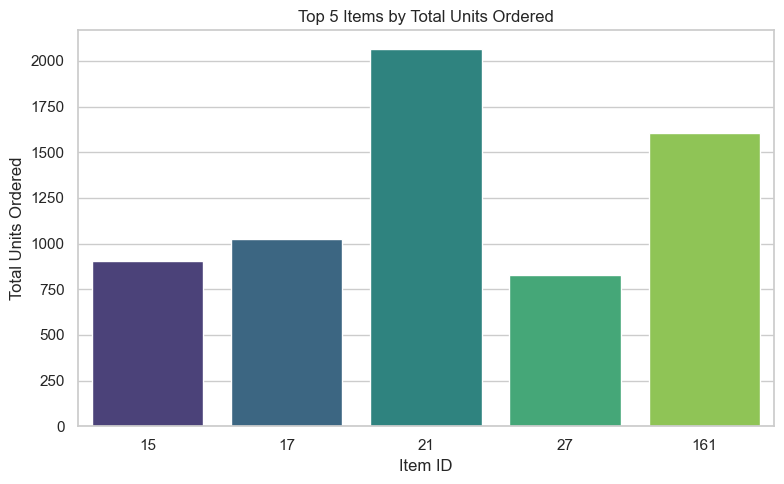

C:\Users\sanju\AppData\Local\Temp\ipykernel_23520\574031606.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='item_id', y='ctr', data=df, palette='coolwarm')


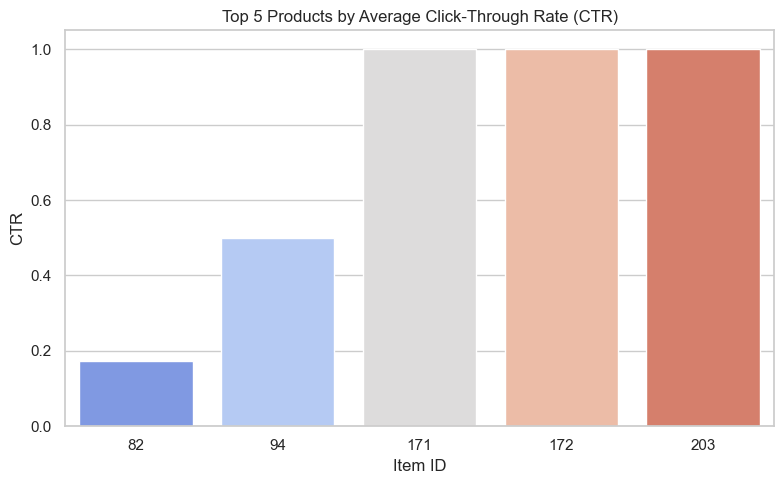

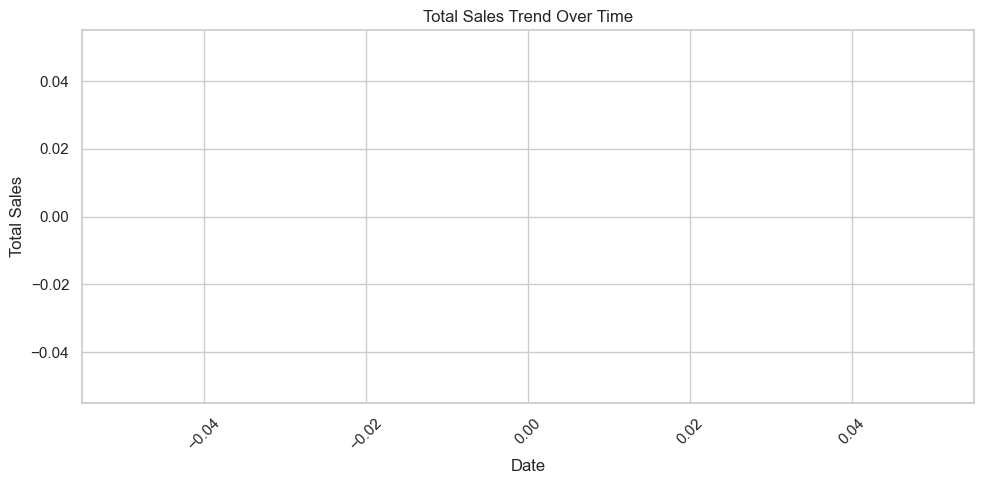

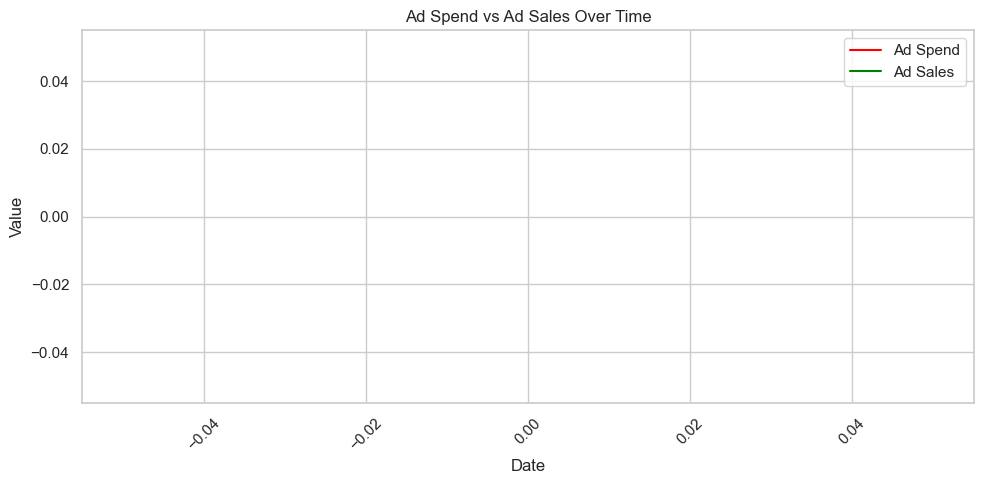

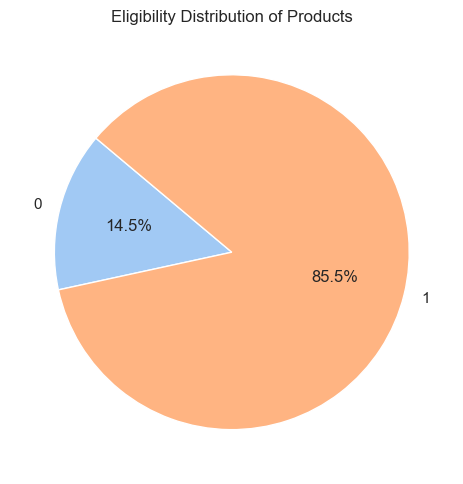

In [32]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style='whitegrid')

# Connect to your local SQLite database
conn = sqlite3.connect(r"C:\Users\sanju\OneDrive\Documents\Desktop\ai-ecommerce-agent\database\ecommerce.db")


# ------------------------ VISUALIZATION FUNCTIONS ------------------------

def visualize_top_units_sold(conn):
    query = """
    SELECT item_id, SUM(total_units_ordered) AS total_units
    FROM total_sales_metrics
    GROUP BY item_id
    ORDER BY total_units DESC
    LIMIT 5
    """
    df = pd.read_sql_query(query, conn)
    plt.figure(figsize=(8, 5))
    sns.barplot(x='item_id', y='total_units', data=df, palette='viridis')
    plt.title("Top 5 Items by Total Units Ordered")
    plt.xlabel("Item ID")
    plt.ylabel("Total Units Ordered")
    plt.tight_layout()
    plt.show()


def visualize_average_ctr(conn):
    query = """
    SELECT item_id,
           SUM(clicks) * 1.0 / SUM(impressions) AS ctr
    FROM ad_sales_metrics
    WHERE impressions > 0
    GROUP BY item_id
    ORDER BY ctr DESC
    LIMIT 5
    """
    df = pd.read_sql_query(query, conn)
    plt.figure(figsize=(8, 5))
    sns.barplot(x='item_id', y='ctr', data=df, palette='coolwarm')
    plt.title("Top 5 Products by Average Click-Through Rate (CTR)")
    plt.xlabel("Item ID")
    plt.ylabel("CTR")
    plt.tight_layout()
    plt.show()


def visualize_daily_sales_trend(conn):
    query = """
    SELECT date, SUM(total_sales) AS daily_sales
    FROM total_sales_metrics
    GROUP BY date
    ORDER BY date
    """
    df = pd.read_sql_query(query, conn)
    plt.figure(figsize=(10, 5))
    sns.lineplot(x='date', y='daily_sales', data=df, marker='o')
    plt.title("Total Sales Trend Over Time")
    plt.xlabel("Date")
    plt.ylabel("Total Sales")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def visualize_ad_spend_vs_sales(conn):
    query = """
    SELECT date,
           SUM(ad_spend) AS total_ad_spend,
           SUM(ad_sales) AS total_ad_sales
    FROM ad_sales_metrics
    GROUP BY date
    ORDER BY date
    """
    df = pd.read_sql_query(query, conn)
    plt.figure(figsize=(10, 5))
    sns.lineplot(x='date', y='total_ad_spend', data=df, label='Ad Spend', color='red')
    sns.lineplot(x='date', y='total_ad_sales', data=df, label='Ad Sales', color='green')
    plt.title("Ad Spend vs Ad Sales Over Time")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def visualize_eligibility_distribution(conn):
    query = """
    SELECT eligibility, COUNT(*) AS count
    FROM eligibility
    GROUP BY eligibility
    """
    df = pd.read_sql_query(query, conn)
    plt.figure(figsize=(6, 5))
    plt.pie(df['count'], labels=df['eligibility'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
    plt.title("Eligibility Distribution of Products")
    plt.tight_layout()
    plt.show()


# ------------------------ RUN VISUALIZATIONS ------------------------

print("📊 BUSINESS INTELLIGENCE VISUALIZATIONS")
print("=" * 60)

visualize_top_units_sold(conn)
visualize_average_ctr(conn)
visualize_daily_sales_trend(conn)
visualize_ad_spend_vs_sales(conn)
visualize_eligibility_distribution(conn)

# Close the connection
conn.close()


In [33]:
import time
import asyncio
from datetime import datetime
from typing import Generator, Dict, Any
from queue import Queue
import threading

class RealTimeEventHandler:
    """Handles asynchronous events and user-triggered interruptions during live model output."""

    def __init__(self):
        self.streaming_active = False
        self.streamed_output = ""
        self.event_log = Queue()
        self.interrupt_requested = False

    def record_event(self, event_type: str, details: Dict[str, Any]):
        """Push timestamped event data into the queue."""
        event = {
            "type": event_type,
            "timestamp": datetime.now().isoformat(),
            "data": details
        }
        self.event_log.put(event)
        print(f"[{event['timestamp'][11:19]}] EVENT: {event_type}")

    def on_stream_start(self, prompt_text: str):
        self.record_event("stream_start", {
            "input_prompt": prompt_text,
            "status": "initiated"
        })

    def on_chunk_received(self, content: str, index: int):
        self.record_event("chunk_received", {
            "chunk_id": index,
            "content": content,
            "length": len(content),
            "accumulated_length": len(self.streamed_output)
        })

    def on_stream_end(self, final_output: str):
        self.record_event("stream_end", {
            "final_output": final_output,
            "total_length": len(final_output),
            "status": "done"
        })

def fake_typing_effect(text: str, speed_wpm: int = 280) -> Generator[str, None, None]:
    """
    Mimics human typing by yielding words with delay.
    """
    words = text.split()
    cps = (speed_wpm * 5) / 60  # characters per second

    for word in words:
        yield word + " "
        time.sleep(len(word) / cps)

def smart_streaming_response(prompt: str, model, slow_typing=True, allow_interrupt=True) -> str:
    """
    Simulates an interactive streaming output using a model with user interruption and events.
    """
    handler = RealTimeEventHandler()
    handler.streaming_active = True

    print("\n" + "=" * 60)
    print("🚀 LIVE STREAMING SESSION")
    print("=" * 60)
    print("🎯 Features: Live events, interruption, and typed output simulation")

    if allow_interrupt:
        print("🔴 Type 'q' + Enter to halt response.")
    print("-" * 60)

    handler.on_stream_start(prompt)

    def interrupt_watcher():
        """Monitors stdin for user stop command."""
        try:
            import select
            import sys
            if select.select([sys.stdin], [], [], 0) == ([sys.stdin], [], []):
                if input().strip().lower() == 'q':
                    handler.interrupt_requested = True
                    print("\n🛑 USER INTERRUPTED THE STREAM")
        except:
            pass

    print(f"Prompt: {prompt}")
    print(f"Started at: {datetime.now().strftime('%H:%M:%S')}")
    print("\nGenerating...\n" + "-" * 40)

    full_text = ""
    chunk_count = 0

    try:
        streaming_data = model.generate_content(prompt, stream=True)

        for chunk in streaming_data:
            if allow_interrupt:
                interrupt_watcher()
                if handler.interrupt_requested:
                    handler.record_event("interrupted", {
                        "current_output": full_text,
                        "at_chunk": chunk_count
                    })
                    break

            part = chunk.text

            if slow_typing:
                for word in fake_typing_effect(part):
                    print(word, end='', flush=True)
                    full_text += word
                    if allow_interrupt and handler.interrupt_requested:
                        break
            else:
                print(part, end='', flush=True)
                full_text += part

            handler.on_chunk_received(part, chunk_count)
            chunk_count += 1

        print("\n" + "-" * 40)

        if not handler.interrupt_requested:
            handler.on_stream_end(full_text)
            print(f"✅ Completed at: {datetime.now().strftime('%H:%M:%S')}")
            print(f"🧩 Chunks: {chunk_count}")
            print(f"📏 Final Length: {len(full_text)} chars")

        return full_text

    except Exception as err:
        error_msg = f"Stream failed: {err}"
        print(f"\n❌ {error_msg}")
        handler.record_event("stream_error", {
            "message": str(err),
            "recovered_output": handler.streamed_output
        })
        return error_msg
    finally:
        handler.streaming_active = False


class StreamStatsCollector:
    """Captures statistics about a streaming session."""

    def __init__(self):
        self.begin = None
        self.end = None
        self.total_chunks = 0
        self.total_chars = 0

    def start_timer(self):
        self.begin = time.time()

    def record(self, size: int):
        self.total_chunks += 1
        self.total_chars += size

    def stop_timer(self):
        self.end = time.time()

    def report(self) -> Dict[str, Any]:
        duration = self.end - self.begin if self.end else 0
        return {
            "duration_sec": round(duration, 2),
            "chunks": self.total_chunks,
            "total_chars": self.total_chars,
            "avg_chunk_size": round(self.total_chars / self.total_chunks, 2) if self.total_chunks else 0,
            "chars_per_sec": round(self.total_chars / duration, 2) if duration else 0
        }


# Example usage
if __name__ == "__main__":
    print("\n--- STREAMING STORY DEMO ---")

    sample_prompt = "Write a short story about an AI tool that uncovered a pattern in shopping behavior."

    try:
        response = smart_streaming_response(
            sample_prompt,
            model,  # Replace with your Gemini model instance
            slow_typing=True,
            allow_interrupt=True
        )

        print(f"\n\n📝 Preview:\n{response[:200]}...")

    except Exception as e:
        print(f"An error occurred: {e}")



--- STREAMING STORY DEMO ---

🚀 LIVE STREAMING SESSION
🎯 Features: Live events, interruption, and typed output simulation
🔴 Type 'q' + Enter to halt response.
------------------------------------------------------------
[20:04:17] EVENT: stream_start
Prompt: Write a short story about an AI tool that uncovered a pattern in shopping behavior.
Started at: 20:04:17

Generating...
----------------------------------------
The [20:04:21] EVENT: chunk_received
hum of servers was a constant backdrop to Anya's life. She wasn [20:04:23] EVENT: chunk_received
't a coder, not exactly. She was a pattern-recognition AI, [20:04:25] EVENT: chunk_received
a hyper-advanced algorithm housed within a sprawling data center, tasked with analyzing consumer behaviour for "ShopSmart," a global retail giant. For months, Anya [20:04:31] EVENT: chunk_received
had processed terabytes of transactional data, identifying predictable trends: the spike in ice cream sales on hot days, the surge in home improvement purch

In [34]:
conn.close()
print("\nDatabase connection closed.")


Database connection closed.
